In [1]:
import geopandas
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas

from esda.adbscan import ADBSCAN, get_cluster_boundary, remap_lbls

- Set up three clusters

<Axes: xlabel='X', ylabel='Y'>

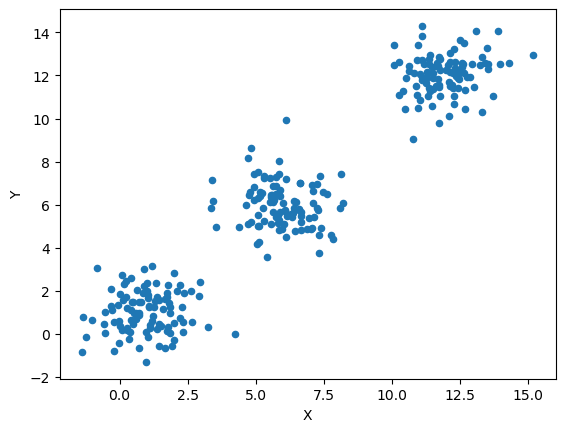

In [2]:
n = 100
np.random.seed(12345)
c1 = np.random.normal(1, 1, (n, 2))
c2 = np.random.normal(6, 1, (n, 2))
c3 = np.random.normal(12, 1, (n, 2))
db = (
    pandas.concat(map(pandas.DataFrame, [c1, c2, c3]))
    .rename(columns={0: "X", 1: "Y"})
    .reset_index()
    .drop("index", axis=1)
)
db.plot.scatter("X", "Y")

- Run A-DBSCAN

Min. samples: 10
['2' '0' '1']


<Axes: xlabel='X', ylabel='Y'>

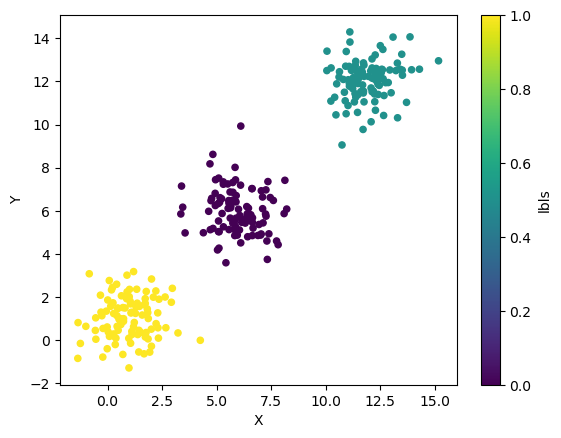

In [3]:
ms = int(n / 10)
print(f"Min. samples: {ms}")
ad = ADBSCAN(2.5, ms, reps=100, keep_solus=True)
np.random.seed(1234)
ad.fit(db)
solus_rl = remap_lbls(ad.solus, db)

ls = list(map(int, ad.labels_))
ls = pandas.Series(ls) / max(ls)
print(ad.votes["lbls"].unique())
db.assign(lbls=ls).plot.scatter("X", "Y", c="lbls", cmap="viridis")

* Create boundary of clusters

In [4]:
polys = get_cluster_boundary(ad.votes["lbls"], db)

<Axes: xlabel='X', ylabel='Y'>

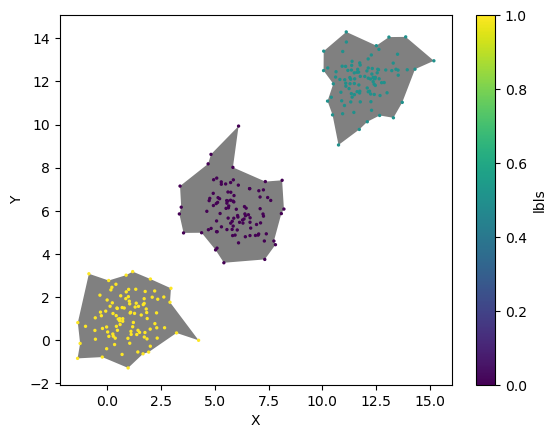

In [5]:
ax = polys.plot(color="0.5")
db.assign(lbls=ls).plot.scatter("X", "Y", c="lbls", cmap="viridis", s=2, ax=ax)

- Explore boundary stability

In [6]:
%%time
lines = []
for rep in solus_rl:
    line = get_cluster_boundary(solus_rl[rep], db, n_jobs=-1)
    line = line.boundary
    line = (
        line.reset_index()
        .rename(columns={0: "geometry", "index": "cluster_id"})
        .assign(rep=rep)
    )
    lines.append(line)
lines = pandas.concat(lines)
lines = geopandas.GeoDataFrame(lines)

CPU times: user 925 ms, sys: 4.19 s, total: 5.11 s
Wall time: 6min 20s


<Axes: >

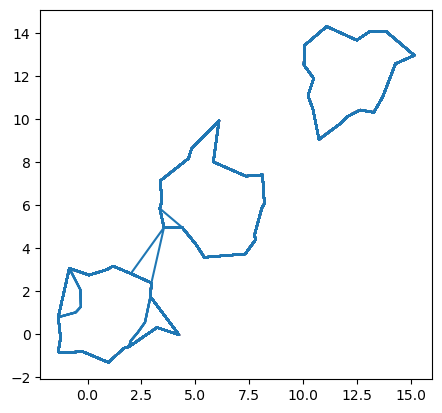

In [7]:
lines.plot()

- Interactive widget to explore different solutions across replications

In [8]:
from ipywidgets import IntSlider, interact

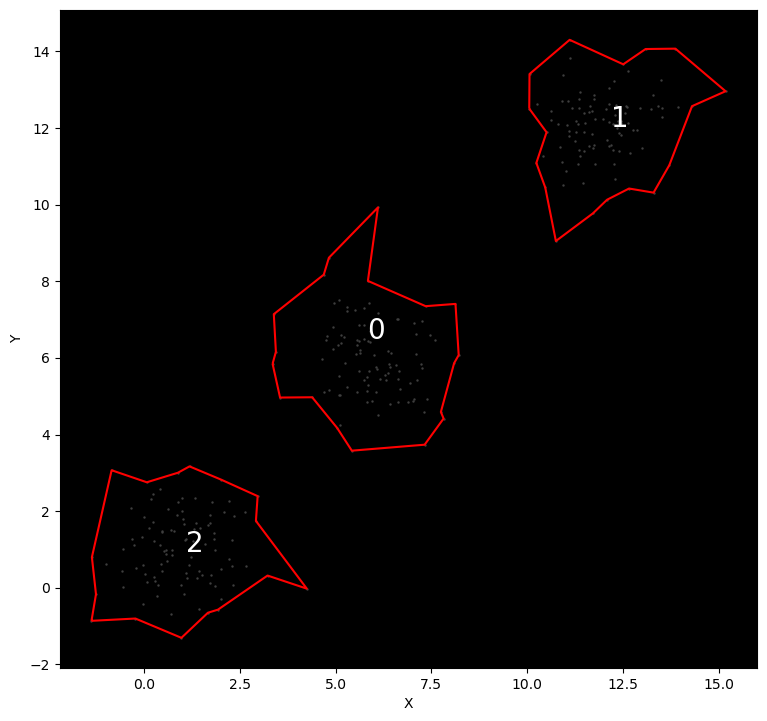

interactive(children=(IntSlider(value=0, description='rep', max=99), Output()), _dom_classes=('widget-interact…

In [9]:
def plot_rep(rep):
    f, ax = plt.subplots(1, figsize=(9, 9))
    ax.set_facecolor("k")
    # Background points
    db[["X", "Y"]].plot.scatter("X", "Y", ax=ax, color="0.25", s=0.5)
    # Boundaries
    cs = lines.query(f"rep == 'rep-{str(rep).zfill(3)}'")
    cs.plot(ax=ax, color="red")
    # Cluster IDs
    for s, row in cs.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, s, size=20, c="w")
    return None


reps = range(len(lines["rep"].unique()))
slider = IntSlider(min=min(reps), max=max(reps), step=1)
interact(plot_rep, rep=slider);